In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import math

from glob import glob
from PIL import Image
from tqdm import tqdm, tqdm_notebook
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, accuracy_score
from time import sleep

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import transforms, utils
from torchvision.transforms import Resize, ToTensor, Normalize
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler

## Model Labeling

In [3]:
df = pd.read_csv('/opt/ml/code/data/Final.csv')
df.head()

,id,path,age,gender,stem,img_path,gender_issue,mask_issue
0,000001,000001_female_Asian_45,45,female,mask1,/opt/ml/input/data/train/images/000001_female_...,False,False
1,000001,000001_female_Asian_45,45,female,mask2,/opt/ml/input/data/train/images/000001_female_...,False,False
2,000001,000001_female_Asian_45,45,female,mask4,/opt/ml/input/data/train/images/000001_female_...,False,False
3,000001,000001_female_Asian_45,45,female,mask3,/opt/ml/input/data/train/images/000001_female_...,False,False
4,000001,000001_female_Asian_45,45,female,incorrect_mask,/opt/ml/input/data/train/images/000001_female_...,False,False


In [4]:
df['label'] = ''
for i in range(len(df)) :
    label = 0
    # 나이를 기준으로 점수
    if df['age'][i] < 30 :
        label = 0
    elif 30 <= df['age'][i] < 60 :
        label = 1
    elif 60 <= df['age'][i] :
        label = 2
    
    # 여자일 경우 남자의 label +3
    if df['gender'][i] == 'female' :
        label += 3
    
    # mask상태가 Not wear일 경우 + 12, Incorrect일 경우 + 6
    if df['stem'][i] == 'normal' :
        label += 12
    elif df['stem'][i] == 'incorrect_mask' :
        label += 6
    
    df['label'][i] = label

In [5]:
df.sample(10)

,id,path,age,gender,stem,img_path,gender_issue,mask_issue,label
234,000041,000041_female_Asian_58,58,female,mask3,/opt/ml/input/data/train/images/000041_female_...,False,False,4
1223,000556,000556_male_Asian_57,57,male,mask5,/opt/ml/input/data/train/images/000556_male_As...,False,False,1
18697,006752,006752_male_Asian_19,19,male,mask1,/opt/ml/input/data/train/images/006752_male_As...,False,False,0
11820,003874,003874_male_Asian_60,60,male,incorrect_mask,/opt/ml/input/data/train/images/003874_male_As...,False,False,8
10755,003653,003653_male_Asian_54,54,male,mask3,/opt/ml/input/data/train/images/003653_male_As...,False,False,1
12707,004279,004279_female_Asian_60,60,female,mask4,/opt/ml/input/data/train/images/004279_female_...,False,False,5
8259,003135,003135_female_Asian_20,20,female,normal,/opt/ml/input/data/train/images/003135_female_...,False,False,15
10960,003719,003719_male_Asian_60,60,male,mask5,/opt/ml/input/data/train/images/003719_male_As...,False,False,2
15107,005443,005443_female_Asian_23,23,female,mask2,/opt/ml/input/data/train/images/005443_female_...,False,False,3
18391,006686,006686_male_Asian_20,20,male,mask4,/opt/ml/input/data/train/images/006686_male_As...,False,False,0


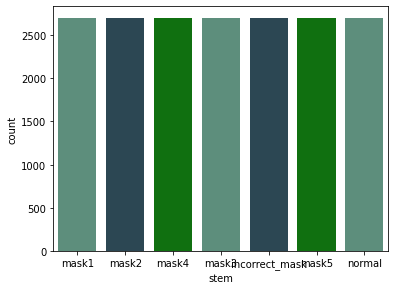

In [6]:
plt.figure(figsize = (6,4.5))
ax = sns.countplot(x = 'stem', data = df, palette = ['#55967e', '#264959', 'green'])

In [7]:
check = dict(df['age'].value_counts())
sorted(check.items(), key = lambda x : x[0])

[(18, 1344),
 (19, 2849),
 (20, 1869),
 (21, 287),
 (22, 406),
 (23, 504),
 (24, 434),
 (25, 574),
 (26, 308),
 (27, 105),
 (28, 175),
 (29, 112),
 (30, 119),
 (31, 21),
 (32, 49),
 (33, 35),
 (34, 91),
 (35, 133),
 (36, 56),
 (37, 21),
 (38, 98),
 (39, 42),
 (40, 140),
 (41, 49),
 (42, 91),
 (43, 126),
 (44, 91),
 (45, 189),
 (46, 98),
 (47, 70),
 (48, 273),
 (49, 217),
 (50, 560),
 (51, 441),
 (52, 546),
 (53, 448),
 (54, 574),
 (55, 700),
 (56, 861),
 (57, 742),
 (58, 1113),
 (59, 595),
 (60, 1344)]

## Define Dataset

In [8]:
class MaskDataset(Dataset) :
    def __init__(self, path_list, label_list, age_list, gender_list, mask_list, transform, aug_transform = None, need = False) :
        self.X = []
        self.y = []
        self.transform = transform
        self.aug_transform = aug_transform
        
        for path, label, age, gender, mask in tqdm_notebook(zip(path_list, label_list, age_list, gender_list, mask_list)) :
            image = Image.open(path)
            self.X.append(image)
            self.y.append(label)
            if need :
                if 21 <= age <= 26 and gender == 'male' and len(mask) == 5 :
                    for _ in range(1) :
                        self.y.append(label)
                        self.X.append(Image.fromarray(self.aug_transform(image = np.array(image))['image']))
                elif 21 <= age <= 26 and gender == 'male' :
                    for _ in range(10) :
                        self.y.append(label)
                        self.X.append(Image.fromarray(self.aug_transform(image = np.array(image))['image']))
                elif 21 <= age <= 26 and gender == 'female' and len(mask) == 5 :
                    for _ in range(1) :
                        self.y.append(label)
                        self.X.append(Image.fromarray(self.aug_transform(image = np.array(image))['image']))
                elif 21 <= age <= 26 and gender == 'female' :
                    for _ in range(10) :
                        self.y.append(label)
                        self.X.append(Image.fromarray(self.aug_transform(image = np.array(image))['image']))
                elif 27 <= age <= 47 and gender == 'male' and len(mask) == 5 :
                    for _ in range(5) :
                        self.y.append(label)
                        self.X.append(Image.fromarray(self.aug_transform(image = np.array(image))['image']))
                elif 27 <= age <= 47 and gender == 'male' :
                    for _ in range(8) :
                        self.y.append(label)
                        self.X.append(Image.fromarray(self.aug_transform(image = np.array(image))['image']))
                elif 27 <= age <= 47 and gender == 'female' and len(mask) == 5:
                    for _ in range(5) :
                        self.y.append(label)
                        self.X.append(Image.fromarray(self.aug_transform(image = np.array(image))['image']))
                elif 27 <= age <= 47 and gender == 'female' :
                    for _ in range(8) :
                        self.y.append(label)
                        self.X.append(Image.fromarray(self.aug_transform(image = np.array(image))['image']))
                elif 48 <= age <= 54 and gender == 'male' and len(mask) == 5 :
                    for _ in range(2) :
                        self.y.append(label)
                        self.X.append(Image.fromarray(self.aug_transform(image = np.array(image))['image']))
                elif 48 <= age <= 54 and gender == 'male' :
                    for _ in range(2) :
                        self.y.append(label)
                        self.X.append(Image.fromarray(self.aug_transform(image = np.array(image))['image']))
                elif 48 <= age <= 54 and gender == 'female' and len(mask) == 5:
                    for _ in range(2) :
                        self.y.append(label)
                        self.X.append(Image.fromarray(self.aug_transform(image = np.array(image))['image']))
                elif 48 <= age <= 54 and gender == 'female' :
                    for _ in range(2) :
                        self.y.append(label)
                        self.X.append(Image.fromarray(self.aug_transform(image = np.array(image))['image']))
    
    def __getitem__(self, idx) :
        X = self.X[idx]
        y = self.y[idx]
        X = self.transform(image = np.array(X))['image']
        return torch.tensor(X, dtype = torch.float), torch.tensor(y, dtype = torch.long)
        
    def __len__(self) :
        len_dataset = len(self.X)
        return len_dataset

In [9]:
data_path = df['img_path']
target = np.array(df['label'])
age_list = np.array(df['age'])
gender_list = np.array(df['gender'])
mask_list = np.array(df['stem'])

### ResNext50_32x4d With Augmentation

In [10]:
model = torchvision.models.resnext50_32x4d(pretrained=True)
model.fc = nn.Sequential(
    nn.Linear(2048, 1024, bias = True),
    nn.ReLU(inplace = True),
    nn.Dropout(p = 0.3),
    nn.Linear(1024, 256, bias = True),
    nn.ReLU(inplace = True),
    nn.Dropout(p = 0.3),
    nn.Linear(256, 18, bias = True))

torch.nn.init.xavier_uniform_(model.fc[0].weight)
stdv = 1.0 / np.sqrt(model.fc[0].in_features)
model.fc[0].bias.data.uniform_(-stdv,stdv)

for param in model.parameters() : # frozon
    param.requires_grad = True

In [12]:
from albumentations import *
from albumentations.pytorch import ToTensorV2

torch.cuda.empty_cache()
stf = StratifiedKFold(n_splits = 4, shuffle = True, random_state =42)
foldperf = {}
for fold, (train_idx, valid_idx) in enumerate(stf.split(data_path, list(target))) :
    
    print('Fold {}'.format(fold + 1))
    target_array = np.array(target)
    
    dataset_train_Mask = MaskDataset(path_list = data_path[train_idx],
                                     label_list = target[train_idx],
                                     age_list = age_list[train_idx],
                                     gender_list = gender_list[train_idx],
                                     mask_list = mask_list[train_idx],
                                     transform = Compose([
                                             Resize(512, 384, p = 1.0),
                                             Normalize(mean = (0.5,0.5,0.5), std = (0.2, 0.2, 0.2), max_pixel_value = 255.0, p = 1.0),
                                             ToTensorV2(p = 1.0),
                                     ]),
                                     aug_transform = Compose([
                                         Resize(512, 384, p = 1.0),
                                         HorizontalFlip(p = 0.5),
                                         RandomBrightnessContrast(brightness_limit = (-0.3, 0.3), contrast_limit = (-0.3, 0.3), p = 1.0),
                                         GaussNoise(var_limit = (1000, 1600), p = 1.0),
                                         CLAHE(p = 1.0),
                                         Equalize(p = 1.0),
                                         ShiftScaleRotate(p = 1.0),
                                      ]),
                                     need = True
                                      )
    dataset_valid_Mask = MaskDataset(path_list = data_path[valid_idx],
                                     label_list = target[valid_idx],
                                     age_list = age_list[valid_idx],
                                     gender_list = gender_list[valid_idx],
                                     mask_list = mask_list[valid_idx],
                                     transform = Compose([
                                             Resize(512, 384, p = 1.0),
                                             Normalize(mean = (0.5,0.5,0.5), std = (0.2, 0.2, 0.2), max_pixel_value = 255.0, p = 1.0),
                                             ToTensorV2(p = 1.0),
                                     ]))
    BATCH_SIZE = 64
    mask_train_dataloader = torch.utils.data.DataLoader(dataset_train_Mask,
                                                        batch_size = BATCH_SIZE,
                                                        shuffle = True)
    mask_valid_dataloader = torch.utils.data.DataLoader(dataset_valid_Mask,
                                                        batch_size = BATCH_SIZE,
                                                        shuffle = True)
    
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print(f'{device} is using !')
    sleep(1)
    
    model = model.to(device)

    LEARNING_RATE = 0.0001
    NUM_EPOCH = 100

    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

    dataloaders = {
        'train' : mask_train_dataloader,
        'test' : mask_valid_dataloader
    }
    
    history = {'train_loss' : [], 'test_loss' : [],
               'train_acc' : [], 'test_acc' : [],
               'train_f1' : [], 'test_f1' : []}
    
    n_epochs_stop = 3
    epochs_no_improve = 0
    early_stop = False
    min_val_loss = np.Inf
    
    best_test_accuracy = 0
    best_test_loss = 9999.
    for epoch in range(5) :
        for phase in ['train', 'test'] :
            running_loss = 0.
            running_acc = 0.
            running_f1 = 0.
            n_iter = 0
            
            if phase == 'train' :
                model.train()
            elif phase == 'test' :
                model.eval()

            for ind, (images, labels) in enumerate(tqdm(dataloaders[phase])) :
                images = images.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train') : # phase == 'train'일 경우에만 grad_enabled를 True
                    logits = model(images)
                    _, preds = torch.max(logits, 1)
                    loss = loss_fn(logits, labels)
                    
                    if phase == 'train' :
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * images.size(0)
                running_acc += torch.sum(preds == labels.data)
                running_f1 += f1_score(preds.cpu().numpy(), labels.cpu().numpy(), average = 'macro')
                n_iter += 1

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_acc / len(dataloaders[phase].dataset)
            epoch_f1 = running_f1 / n_iter
            #epoch_f1_check = running_f1 / len(dataloaders[phase].dataset)
            #print('n_iter는 ', n_iter, ' dataset는 :', len(dataloaders[phase].dataset))
            #print('n_iter :', epoch_f1, ' dataset :', epoch_f1_check)
            
            if phase == 'test' :
                if epoch_loss < min_val_loss :
                    epochs_no_improve = 0
                    min_val_loss = epoch_loss
                else :
                    epochs_no_improve += 1
                
                if epochs_no_improve == n_epochs_stop :
                    print('Early Stopping!')
                    early_stop = True
                    break
            
            if phase == 'train' :
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc)
                history['train_f1'].append(epoch_f1)
            elif phase == 'test' :
                history['test_loss'].append(epoch_loss)
                history['test_acc'].append(epoch_acc)
                history['test_f1'].append(epoch_f1)

            print(f"현재 epoch-{epoch}의 {phase}-데이터 셋에서 평균 Loss : {epoch_loss:.4f}, 평균 Accuracy : {epoch_acc:.4f}, 평균 F1 Score : {epoch_f1: .4f}")
            #if phase == "test" and best_test_accuracy < epoch_acc: # phase가 test일 때, best accuracy 계산
            #    best_test_accuracy = epoch_acc
            #if phase == "test" and best_test_loss > epoch_loss: # phase가 test일 때, best loss 계산
            #    best_test_loss = epoch_loss
    
        if early_stop :
            print(f'fold{fold+1} Stopped')
            break
    foldperf['fold{}'.format(fold+1)] = history 
    
    #print("학습 종료!")
    #print(f"최고 accuracy : {best_test_accuracy}, 최고 낮은 loss : {best_test_loss}")

Fold 1



cuda:0 is using !


  0%|          | 0/74 [00:00<?, ?it/s]

현재 epoch-0의 train-데이터 셋에서 평균 Loss : 0.5421, 평균 Accuracy : 0.8312, 평균 F1 Score :  0.7187


  0%|          | 0/526 [00:00<?, ?it/s]

현재 epoch-0의 test-데이터 셋에서 평균 Loss : 0.1503, 평균 Accuracy : 0.9498, 평균 F1 Score :  0.8763


  0%|          | 0/74 [00:00<?, ?it/s]

현재 epoch-1의 train-데이터 셋에서 평균 Loss : 0.0938, 평균 Accuracy : 0.9693, 평균 F1 Score :  0.9275


  0%|          | 0/526 [00:00<?, ?it/s]

현재 epoch-1의 test-데이터 셋에서 평균 Loss : 0.0675, 평균 Accuracy : 0.9790, 평균 F1 Score :  0.9407


  0%|          | 0/74 [00:00<?, ?it/s]

현재 epoch-2의 train-데이터 셋에서 평균 Loss : 0.0565, 평균 Accuracy : 0.9825, 평균 F1 Score :  0.9624


  0%|          | 0/526 [00:00<?, ?it/s]

현재 epoch-2의 test-데이터 셋에서 평균 Loss : 0.0672, 평균 Accuracy : 0.9752, 평균 F1 Score :  0.9308


  0%|          | 0/74 [00:00<?, ?it/s]

현재 epoch-3의 train-데이터 셋에서 평균 Loss : 0.0433, 평균 Accuracy : 0.9858, 평균 F1 Score :  0.9703


  0%|          | 0/526 [00:00<?, ?it/s]

현재 epoch-3의 test-데이터 셋에서 평균 Loss : 0.0418, 평균 Accuracy : 0.9873, 평균 F1 Score :  0.9729


  0%|          | 0/74 [00:00<?, ?it/s]

현재 epoch-4의 train-데이터 셋에서 평균 Loss : 0.0296, 평균 Accuracy : 0.9905, 평균 F1 Score :  0.9811


100%|██████████| 74/74 [00:43<00:00,  1.72it/s]

현재 epoch-4의 test-데이터 셋에서 평균 Loss : 0.0432, 평균 Accuracy : 0.9877, 평균 F1 Score :  0.9681
Fold 2



cuda:0 is using !


  0%|          | 0/74 [00:00<?, ?it/s]

현재 epoch-0의 train-데이터 셋에서 평균 Loss : 0.0590, 평균 Accuracy : 0.9814, 평균 F1 Score :  0.9667


  0%|          | 0/530 [00:00<?, ?it/s]

현재 epoch-0의 test-데이터 셋에서 평균 Loss : 0.0091, 평균 Accuracy : 0.9972, 평균 F1 Score :  0.9956


  0%|          | 0/74 [00:00<?, ?it/s]

현재 epoch-1의 train-데이터 셋에서 평균 Loss : 0.0327, 평균 Accuracy : 0.9894, 평균 F1 Score :  0.9793


  0%|          | 0/530 [00:00<?, ?it/s]

현재 epoch-1의 test-데이터 셋에서 평균 Loss : 0.0289, 평균 Accuracy : 0.9894, 평균 F1 Score :  0.9616


  0%|          | 0/74 [00:00<?, ?it/s]

현재 epoch-2의 train-데이터 셋에서 평균 Loss : 0.0298, 평균 Accuracy : 0.9908, 평균 F1 Score :  0.9819


  0%|          | 0/530 [00:00<?, ?it/s]

현재 epoch-2의 test-데이터 셋에서 평균 Loss : 0.0325, 평균 Accuracy : 0.9886, 평균 F1 Score :  0.9739


  0%|          | 0/74 [00:00<?, ?it/s]

현재 epoch-3의 train-데이터 셋에서 평균 Loss : 0.0266, 평균 Accuracy : 0.9919, 평균 F1 Score :  0.9828


100%|██████████| 74/74 [00:39<00:00,  1.85it/s]

Early Stopping!
fold2 Stopped
Fold 3



cuda:0 is using !


  0%|          | 0/74 [00:00<?, ?it/s]

현재 epoch-0의 train-데이터 셋에서 평균 Loss : 0.0366, 평균 Accuracy : 0.9882, 평균 F1 Score :  0.9789


  0%|          | 0/532 [00:00<?, ?it/s]

현재 epoch-0의 test-데이터 셋에서 평균 Loss : 0.0021, 평균 Accuracy : 1.0000, 평균 F1 Score :  1.0000


  0%|          | 0/74 [00:00<?, ?it/s]

현재 epoch-1의 train-데이터 셋에서 평균 Loss : 0.0244, 평균 Accuracy : 0.9918, 평균 F1 Score :  0.9853


  0%|          | 0/532 [00:00<?, ?it/s]

현재 epoch-1의 test-데이터 셋에서 평균 Loss : 0.0118, 평균 Accuracy : 0.9958, 평균 F1 Score :  0.9931


  0%|          | 0/74 [00:00<?, ?it/s]

현재 epoch-2의 train-데이터 셋에서 평균 Loss : 0.0265, 평균 Accuracy : 0.9917, 평균 F1 Score :  0.9853


  0%|          | 0/532 [00:00<?, ?it/s]

현재 epoch-2의 test-데이터 셋에서 평균 Loss : 0.0316, 평균 Accuracy : 0.9937, 평균 F1 Score :  0.9867


  0%|          | 0/74 [00:00<?, ?it/s]

현재 epoch-3의 train-데이터 셋에서 평균 Loss : 0.0237, 평균 Accuracy : 0.9928, 평균 F1 Score :  0.9874


100%|██████████| 74/74 [00:41<00:00,  1.80it/s]

Early Stopping!
fold3 Stopped
Fold 4



cuda:0 is using !


  0%|          | 0/74 [00:00<?, ?it/s]

현재 epoch-0의 train-데이터 셋에서 평균 Loss : 0.0290, 평균 Accuracy : 0.9906, 평균 F1 Score :  0.9837


  0%|          | 0/532 [00:00<?, ?it/s]

현재 epoch-0의 test-데이터 셋에서 평균 Loss : 0.0029, 평균 Accuracy : 0.9989, 평균 F1 Score :  0.9981


  0%|          | 0/74 [00:00<?, ?it/s]

현재 epoch-1의 train-데이터 셋에서 평균 Loss : 0.0228, 평균 Accuracy : 0.9927, 평균 F1 Score :  0.9873


  0%|          | 0/532 [00:00<?, ?it/s]

현재 epoch-1의 test-데이터 셋에서 평균 Loss : 0.0033, 평균 Accuracy : 0.9987, 평균 F1 Score :  0.9966


  0%|          | 0/74 [00:00<?, ?it/s]

현재 epoch-2의 train-데이터 셋에서 평균 Loss : 0.0201, 평균 Accuracy : 0.9935, 평균 F1 Score :  0.9879


  0%|          | 0/532 [00:00<?, ?it/s]

현재 epoch-2의 test-데이터 셋에서 평균 Loss : 0.0470, 평균 Accuracy : 0.9879, 평균 F1 Score :  0.9732


  0%|          | 0/74 [00:00<?, ?it/s]

현재 epoch-3의 train-데이터 셋에서 평균 Loss : 0.0172, 평균 Accuracy : 0.9949, 평균 F1 Score :  0.9908


100%|██████████| 74/74 [00:39<00:00,  1.87it/s]

Early Stopping!
fold4 Stopped


In [13]:
torch.save(model, '/opt/ml/code/model/Resnext50_SKFold4-5-earlystopping-Augmentation.pt')

In [14]:
# 테스트 데이터셋 폴더 경로를 지정해주세요.
test_dir = '/opt/ml/input/data/eval'

In [15]:
# meta 데이터와 이미지 경로를 불러옵니다.
submission = pd.read_csv(os.path.join(test_dir, 'info.csv'))
image_dir = os.path.join(test_dir, 'images')

In [16]:
class TestDataset(Dataset):
    def __init__(self, img_paths, transform):
        self.img_paths = img_paths
        self.transform = transform

    def __getitem__(self, index):
        image = Image.open(self.img_paths[index])

        if self.transform:
            image = self.transform(image)
        return image

    def __len__(self):
        return len(self.img_paths)

In [17]:
from torchvision import transforms, utils
from torchvision.transforms import Resize, ToTensor, Normalize

# Test Dataset 클래스 객체를 생성하고 DataLoader를 만듭니다.
image_paths = [os.path.join(image_dir, img_id) for img_id in submission.ImageID]
transform = transforms.Compose([
    Resize((512, 384), Image.BILINEAR),
    ToTensor(),
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.2, 0.2, 0.2)),
])
dataset = TestDataset(image_paths, transform)

loader = DataLoader(
    dataset,
    shuffle=False
)

In [18]:
device = torch.device('cuda')
model = torch.load('/opt/ml/code/model/Resnext50_SKFold4-5-earlystopping-Augmentation.pt').to(device)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [19]:
# 모델이 테스트 데이터셋을 예측하고 결과를 저장합니다.
all_predictions = []
for images in tqdm(loader):
    with torch.no_grad():
        images = images.to(device)
        pred = model(images)
        pred = pred.argmax(dim=-1)
        all_predictions.extend(pred.cpu().numpy())
submission['ans'] = all_predictions

100%|██████████| 12600/12600 [03:52<00:00, 54.13it/s]


In [20]:
# 제출할 파일을 저장합니다.
submission.to_csv(os.path.join(test_dir, 'submission_tenth.csv'), index=False)
print('test inference is done!')

test inference is done!


In [22]:
len(dataset_train_Mask)

34044

In [33]:
new_y = []
for i in tqdm(range(len(dataset_train_Mask))) :
    new_y.append(dataset_train_Mask[i][1].tolist())

100%|██████████| 34044/34044 [01:45<00:00, 322.00it/s]


In [36]:
new_data = pd.DataFrame(data = new_y, columns = ['class'])

In [38]:
new_data.value_counts()

class
4        8170
3        3930
1        3836
0        3238
6        2104
9        2038
15       2027
16       1992
10       1971
12       1951
7         894
13        885
5         409
2         312
11         82
17         81
14         62
8          62
dtype: int64

In [18]:
X_train, X_valid, y_train, y_valid = train_test_split(data_path,
                                                      target,
                                                      test_size = 0.2,
                                                      shuffle = True)

In [19]:
train_idx_list = list(X_train.index)
valid_idx_list = list(X_valid.index)

In [20]:
from albumentations import *
from albumentations.pytorch import ToTensorV2
dataset_train_Mask = MaskDataset(path_list = data_path[train_idx_list],
                                 label_list = target[train_idx_list],
                                 age_list = age_list[train_idx_list],
                                 gender_list = gender_list[train_idx_list],
                                 mask_list = mask_list[train_idx_list],
                                 transform = Compose([
                                         Resize(512, 384, p = 1.0),
                                         Normalize(mean = (0.5,0.5,0.5), std = (0.2, 0.2, 0.2), max_pixel_value = 255.0, p = 1.0),
                                         ToTensorV2(p = 1.0),
                                 ]),
                                 aug_transform = Compose([
                                     Resize(512, 384, p = 1.0),
                                     HorizontalFlip(p = 0.5),
                                     RandomBrightnessContrast(brightness_limit = (-0.3, 0.3), contrast_limit = (-0.3, 0.3), p = 1.0),
                                     GaussNoise(var_limit = (1000, 1600), p = 1.0),
                                     CLAHE(p = 1.0),
                                     Equalize(p = 1.0),
                                     ShiftScaleRotate(p = 1.0),
                                  ]),
                                 need = True
                                  )
dataset_valid_Mask = MaskDataset(path_list = data_path[valid_idx_list],
                                 label_list = target[valid_idx_list],
                                 age_list = age_list[valid_idx_list],
                                 gender_list = gender_list[valid_idx_list],
                                 mask_list = mask_list[valid_idx_list],
                                 transform = Compose([
                                         Resize(512, 384, p = 1.0),
                                         Normalize(mean = (0.5,0.5,0.5), std = (0.2, 0.2, 0.2), max_pixel_value = 255.0, p = 1.0),
                                         ToTensorV2(p = 1.0),
                                 ]))

In [21]:
BATCH_SIZE = 64
mask_train_dataloader = torch.utils.data.DataLoader(dataset_train_Mask,
                                                    batch_size = BATCH_SIZE,
                                                    shuffle = True)
mask_valid_dataloader = torch.utils.data.DataLoader(dataset_valid_Mask,
                                                    batch_size = BATCH_SIZE,
                                                    shuffle = False)

In [23]:
model = torchvision.models.resnext50_32x4d(pretrained=True)
model.fc = nn.Sequential(
    nn.Linear(2048, 1024, bias = True),
    nn.ReLU(inplace = True),
    nn.Dropout(p = 0.3),
    nn.Linear(1024, 256, bias = True),
    nn.ReLU(inplace = True),
    nn.Dropout(p = 0.3),
    nn.Linear(256, 18, bias = True))

torch.nn.init.xavier_uniform_(model.fc[0].weight)
stdv = 1.0 / np.sqrt(model.fc[0].in_features)
model.fc[0].bias.data.uniform_(-stdv,stdv)

for param in model.parameters() : # frozon
    param.requires_grad = True

In [24]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'{device} is using !')

model = model.to(device)

LEARNING_RATE = 0.0001
NUM_EPOCH = 100

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

dataloaders = {
    'train' : mask_train_dataloader,
    'test' : mask_valid_dataloader
}

n_epochs_stop = 3
epochs_no_improve = 0
early_stop = False
min_val_loss = np.Inf

cuda:0 is using !


In [25]:
best_test_accuracy = 0
best_test_loss = 9999.
for epoch in range(100) :
    for phase in ['train', 'test'] :
        running_loss = 0.
        running_acc = 0.
        running_f1 = 0.
        n_iter = 0

        if phase == 'train' :
            model.train()
        elif phase == 'test' :
            model.eval()

        for ind, (images, labels) in enumerate(tqdm(dataloaders[phase])) :
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train') : # phase == 'train'일 경우에만 grad_enabled를 True
                logits = model(images)
                _, preds = torch.max(logits, 1)
                loss = loss_fn(logits, labels)

                if phase == 'train' :
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * images.size(0)
            running_acc += torch.sum(preds == labels.data)
            running_f1 += f1_score(preds.cpu().numpy(), labels.cpu().numpy(), average = 'macro')
            n_iter += 1

        epoch_loss = running_loss / len(dataloaders[phase].dataset)
        epoch_acc = running_acc / len(dataloaders[phase].dataset)
        epoch_f1 = running_f1 / n_iter

        if phase == 'test' :
            if epoch_loss < min_val_loss :
                epochs_no_improve = 0
                min_val_loss = epoch_loss
            else :
                epochs_no_improve += 1

            if epochs_no_improve == n_epochs_stop :
                print('Early Stopping!')
                early_stop = True
                break

        print(f"현재 epoch-{epoch}의 {phase}-데이터 셋에서 평균 Loss : {epoch_loss:.4f}, 평균 Accuracy : {epoch_acc:.4f}, 평균 F1 Score : {epoch_f1: .4f}")
        if phase == "test" and best_test_accuracy < epoch_acc: # phase가 test일 때, best accuracy 계산
            best_test_accuracy = epoch_acc
        if phase == "test" and best_test_loss > epoch_loss: # phase가 test일 때, best loss 계산
            best_test_loss = epoch_loss

    if early_stop :
        break

print("학습 종료!")
print(f"최고 accuracy : {best_test_accuracy}, 최고 낮은 loss : {best_test_loss}")

  0%|          | 0/60 [00:00<?, ?it/s]

현재 epoch-0의 train-데이터 셋에서 평균 Loss : 0.6915, 평균 Accuracy : 0.7888, 평균 F1 Score :  0.6107


  0%|          | 0/331 [00:00<?, ?it/s]

현재 epoch-0의 test-데이터 셋에서 평균 Loss : 0.2078, 평균 Accuracy : 0.9325, 평균 F1 Score :  0.8160


  0%|          | 1/331 [00:02<12:47,  2.33s/it]


KeyboardInterrupt: 